In [1]:
import finesse
from finesse import Model, BeamParam
from finesse.components import Cavity, Laser, Lens, Mirror
import matplotlib as mpl

finesse.init_plotting()
# Make figures a bit bigger
figsize_x, figsize_y = mpl.rcParams["figure.figsize"]
mpl.rcParams["figure.figsize"] = [1.5 * figsize_x, 1.5 * figsize_y]

## Beam trace optimisation toolbox

I took advantage of Sam's nice work on the tracing toolbox to rewrite the optimisation stuff I made a while ago. The new beam tracing optimisation toolbox provides a powerful interface to both Scipy's `optimize` and [Py-BOBYQA](https://numericalalgorithmsgroup.github.io/pybobyqa/)'s `solve` functions in the context of Finesse beam traces.

In this example, I show how to optimise a cavity's mode matching by varying the position of a lens, given a particular laser beam. The same tools can however be used for essentially any other purpose, so the optimiser is written in a hierarchy of classes to allow for support for other types of optimisation and use of other types of algorithm and cost function.

There are a few improvements that can probably be made to this API, the `Model` object and elsewhere, but it seems to work well enough to show off.

First let's import stuff from the tracing optimisation module.

In [2]:
# Unfortunately, because the optimisation tools are so generic, the concrete user API class names are pretty long.
from finesse.tracing.optimise import (
    TraceOptimiser,
    BoundedAttributeQuantity,
    BoundedComponentPosition,
    LinearAttributeQuantity,
)

First we want to make a model with only the cavity mirrors so we can compute the ideal mode matching case.

It seems like there should be a a way to get a cavity's *ideal* parameters as well as its *current* parameters even once traced, but I couldn't find how to do this so I instead start with the ideal cavity, note its values, then make it non-ideal and optimise back again.

In [3]:
# Make a model with only the cavity mirrors so we can first compute the ideal case.
model = Model()
model.chain(Mirror("m1", Rc=-15), 10, Mirror("m2", Rc=15))
cav = Cavity("cav", model.m1.p2.o)
model.add(cav)

Trace the cavity and grab the beam size at one of the mirrors.

In [4]:
model.beam_trace()

# Save the beam size at the cavity mirrors to set as a target later.
target_beam_w = model.m2.p1.i.q.w

Let's see what this looks like:

cav waist radius: 1.5475275121877161 mm
m2 beam radius: 1.8953263838892904 mm
╒═════════╤═════════╤═══════════╤══════════╤════════════════════╤═══════════╤═══════════════════╤═════════════════╕
│ Name    │   z [m] │   w0 [mm] │   zr [m] │   Beam radius [mm] │   RoC [m] │   Acc. Gouy [deg] │ q               │
╞═════════╪═════════╪═══════════╪══════════╪════════════════════╪═══════════╪═══════════════════╪═════════════════╡
│ m1.p2.o │       0 │   1.54753 │  7.07107 │            1.89533 │       -15 │            0      │ -5.000 + 7.071j │
├─────────┼─────────┼───────────┼──────────┼────────────────────┼───────────┼───────────────────┼─────────────────┤
│ m2.p1.i │      10 │   1.54753 │  7.07107 │            1.89533 │        15 │           70.5288 │ 5.000 + 7.071j  │
╘═════════╧═════════╧═══════════╧══════════╧════════════════════╧═══════════╧═══════════════════╧═════════════════╛


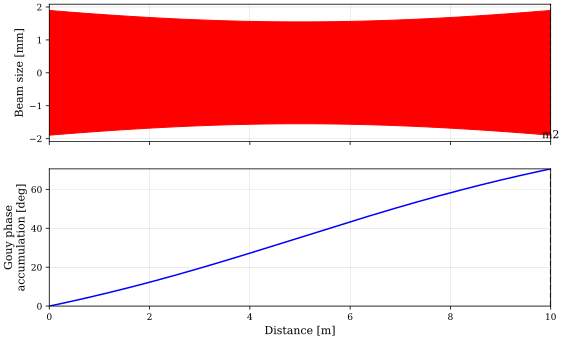

In [5]:
print(f"cav waist radius: {model.cav.q.w0 * 1e3} mm")
print(f"m2 beam radius: {model.m2.p1.i.q.w * 1e3} mm")
ts = model.propagate_beam(model.m1.p2.o, model.m2.p1.i, symbolic=True)
print(ts)
ts.plot();

Now we'll add our input optics, including two lenses we'll use to help mode matching.
Also remove the cavity object from the model otherwise the tracer will match it perfectly again, which is not what we want.

In [6]:
# Add the input path.
model.chain(Laser("lsr"), 1, Lens("l1", f=-1), 1, Lens("l2", f=1))
model.connect(model.l2.p2, model.m1.p1, L=1)

# Remove the cavity so that we can mode match the real laser to the cavity.
model.remove(cav)

Set a typical NPRO beam waist on the laser.

In [7]:
# Set the real laser beam (typical NPRO).
model.lsr.p1.o.q = BeamParam(w0=370e-6, z=-0.09)

Let's see what the mode matching looks like now.

In [8]:
ts = model.propagate_beam(model.lsr.p1.o, model.m2.p1.i, symbolic=True)
print(ts)
ts.plot();

╒══════════╤═════════╤═══════════╤══════════╤════════════════════╤═══════════╤═══════════════════╤═════════════════╕
│ Name     │   z [m] │   w0 [mm] │   zr [m] │   Beam radius [mm] │   RoC [m] │   Acc. Gouy [deg] │ q               │
╞══════════╪═════════╪═══════════╪══════════╪════════════════════╪═══════════╪═══════════════════╪═════════════════╡
│ lsr.p1.o │       0 │  0.37     │ 0.404214 │           0.37906  │ -1.90544  │            0      │ -0.090 + 0.404j │
├──────────┼─────────┼───────────┼──────────┼────────────────────┼───────────┼───────────────────┼─────────────────┤
│ l1.p1.i  │       1 │  0.37     │ 0.404214 │           0.911452 │  1.08955  │           78.602  │ 0.910 + 0.404j  │
├──────────┼─────────┼───────────┼──────────┼────────────────────┼───────────┼───────────────────┼─────────────────┤
│ l1.p2.o  │       1 │  0.18952  │ 0.106052 │           0.911452 │  0.521428 │           78.602  │ 0.499 + 0.106j  │
├──────────┼─────────┼───────────┼──────────┼───────────────────

Clearly we need to optimise the lens positions to mode match the laser to the cavity.
First set up a `TraceOptimiser`:

In [9]:
# Create an optimiser for the model.
optimiser = TraceOptimiser(model=model)

This is simply a container for the model with a few convenience methods. It ultimately subclasses from `finesse.utilities.optimise.core.BaseOptimiser`, and having this hierarchy should allow us to use the same optimisation algorithms for other optimisation problems, or other optimisation algorithms for this problem.

We want to allow the optimiser to move the lens position. One way to do this would be to allow the spaces around the lens to vary:

In [10]:
# Allow the spaces between the lenses to vary.
#optimiser.allow(
#    BoundedAttributeQuantity(
#        item=model.lsr, attribute="p1.o.space.L", bounds=(0.1, 5)
#    )
#)
#optimiser.allow(
#    BoundedAttributeQuantity(
#        item=model.l1, attribute="p2.o.space.L", bounds=(0.1, 5)
#    )
#)

But sometimes you're matching a real system and don't want to move every component after the lens, so it's nice to constrain the overall length of the spaces either side of a component and instead allow the optimiser to move the component within. For this we can use a `BoundedComponentPosition`:

In [11]:
# Allow the spaces between the lenses to vary.
optimiser.allow(BoundedComponentPosition(item=model.l1, bounds=(0.1, 5)))

Now we need to set targets for our optimisation - it needs to know when it's met the objective. For this we use the `target` method, and we'll set the target to the beam size at the two cavity mirrors that we measured at the start.

We use a `LinearAttributeQuantity` which implements a linear cost function for an object's attribute, i.e. `abs(target_value - current_value)`.

In [12]:
# Set target beam size at the cavity mirrors.
optimiser.target(LinearAttributeQuantity(model.m1, "p2.o.q.w", target=target_beam_w))
optimiser.target(LinearAttributeQuantity(model.m2, "p1.i.q.w", target=target_beam_w))

Finally we can optimise, providing whatever options the particular optimisation algorithm under the hood requires.
The underlying optimiser is `scipy.optimize.minimize`, which will choose what it thinks is the best algorithm depending on the inputs. In our case, because we provide bounds, it chooses an algorithm that can deal with them.

Note that the `TraceOptimiser` implements a cost function of its own, in the way it combines the individual costs of each free parameter. In this case it uses incoherent sum but others can be used via multiple inheritance.

In [13]:
optimiser.optimise(rhoend=1e-10)

The optimiser's cost function, called by the underlying optimisation algorithm, updates the model as it goes. That means after optimisation the model contains the optimal values the algorithm found.

We can print the optimiser object to get some information:

In [14]:
print(optimiser)

Optimisation of <finesse.model.Model object at 0x7fbb946e97f0> finished in 30 iterations (Success: rho has reached rhoend)

Targets:
╒═══════════════════════════════════════════╤════════════════╤════════════════════╤═══════════════════╕
│ Parameter                                 │   Target value │ Initial value      │ Current value     │
╞═══════════════════════════════════════════╪════════════════╪════════════════════╪═══════════════════╡
│ <'m1' @ 0x7fbb946e9b20 (Mirror)>.p2.o.q.w │         0.0019 │ 1.79e-03 (21.84%)  │ 2.18e-03 (14.88%) │
├───────────────────────────────────────────┼────────────────┼────────────────────┼───────────────────┤
│ <'m2' @ 0x7fbb9462fc10 (Mirror)>.p1.i.q.w │         0.0019 │ 7.38e-03 (-73.99%) │ 1.92e-03 (1.23%)  │
╘═══════════════════════════════════════════╧════════════════╧════════════════════╧═══════════════════╛

Variables:
╒════════════════════════════════════╤═════════════════╤═══════════════════╕
│ Parameter                          │   Initial v

Let's see what the optimum values look like:

╒══════════╤══════════╤═══════════╤═══════════╤════════════════════╤═══════════╤═══════════════════╤═════════════════╕
│ Name     │    z [m] │   w0 [mm] │    zr [m] │   Beam radius [mm] │   RoC [m] │   Acc. Gouy [deg] │ q               │
╞══════════╪══════════╪═══════════╪═══════════╪════════════════════╪═══════════╪═══════════════════╪═════════════════╡
│ lsr.p1.o │  0       │  0.37     │ 0.404214  │            0.37906 │ -1.90544  │            0      │ -0.090 + 0.404j │
├──────────┼──────────┼───────────┼───────────┼────────────────────┼───────────┼───────────────────┼─────────────────┤
│ l1.p1.i  │  1.43413 │  0.37     │ 0.404214  │            1.28478 │  1.46568  │           85.815  │ 1.344 + 0.404j  │
├──────────┼──────────┼───────────┼───────────┼────────────────────┼───────────┼───────────────────┼─────────────────┤
│ l1.p2.o  │  1.43413 │  0.155546 │ 0.0714372 │            1.28478 │  0.594433 │           85.815  │ 0.586 + 0.071j  │
├──────────┼──────────┼───────────┼───────────┼─

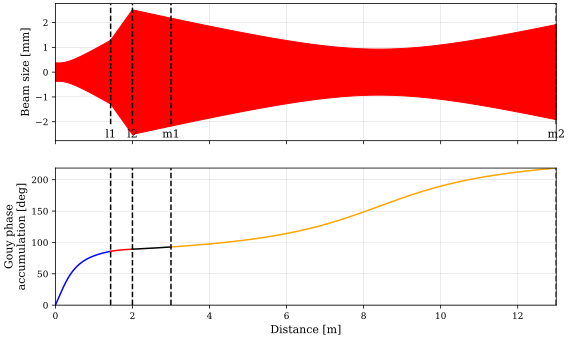

In [15]:
ts = model.propagate_beam(model.lsr.p1.o, model.m2.p1.i, symbolic=True)
print(ts)
ts.plot();

As can be seen from the table above, the optimiser has kept the overall length between `lsr.p1.o` and `l2.p1.i` constant (2 meters) but varied `l1`'s position within (was `1 m`, now `1.43413 m`).

## Future work

 - Easier access to / computation of mode matching figures of merit so we can wrap optimisers around them:
   - *Current* cavity waist size (or is this available somewhere?)
   - Beam size at arbitrary positions, e.g. between optics
   - Mismatch factor at a cavity in a traced model (current `Cavity.mismatch`, `Cavity.overlap` etc. need to be manually provided with `BeamParam` objects?)
   - Maybe some convenience methods in `Model`, like `Model.beam_size_at(component)`?
 - Should we add something to `Model` to allow components to be moved while scaling their connected spaces?
   - How might this work for beam splitters and anything else with >2 ports?
 - Experiment with different cost functions. Currently the above uses linear cost.
 - Support for other optimisation tasks in Finesse, such as optimisation requiring the running of a full model (noise? sensitivity? etc.). For this we would implement a new child class of `BaseOptimiser` to provide problem-specific convenience methods.
 - Sanity checks to make sure negative lengths can't be set, nor parameters overconstrained.
 - Just for fun: apply Sam's `animate` function to the optimiser, so we can visualise how it finds the minimum...
 - "Optimise" or "optimize"?

## Some suggestions for `PropagationSolution`

 - Allow plotting of -ve x-axis values. Some laser waists are behind the laser head.
 - Override the tooltip callback in Matplotlib when viewing a `PropagationSolution` to show the current beam size at the current x position instead of cursor's y position.
 - Allow markers to be added to show the beam size at certain x-values. Like JamMt's beam analyser. Maybe just use "Nothing" components so that they show up in the table of beam parameters when printed?